# Voyages API Use Cases

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/VoyagesAPI-UseCases.ipynb).

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [1]:
!pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

## Voyages API Use Cases


In [ ]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.voyages import Vessel, VesselFilter
from signal_ocean.voyages import VesselType, VesselTypeFilter
from signal_ocean.voyages import VesselClass, VesselClassFilter
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [ ]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

Declare helper functions

In [ ]:
def get_voyage_load_area(voyage_events):
    return next((e.area_name_level0 for e in voyage_events or [] if e.purpose=='Load'), None)

def get_voyage_discharge_country(voyage_events):
    return next((e.country for e in reversed(voyage_events or []) if e.purpose=='Discharge'), None)

def get_voyage_load_country(voyage_events):
    return next((e.country for e in voyage_events or [] if e.purpose=='Load'), None)

### Get voyages

In [ ]:
# get vessel class id for vlcc
vessel_class = api.get_vessel_classes(VesselClassFilter('vlcc'))
vlcc_id = vessel_class[0].vessel_class_id
vlcc_id

84

In [ ]:
date_from = date.today() - timedelta(days=180)

In [ ]:
voyages = api.get_voyages(vessel_class_id=vlcc_id, date_from=date_from)

In [ ]:
voyages = pd.DataFrame(v.__dict__ for v in voyages)
events = pd.DataFrame(e.__dict__ for voyage_events in voyages['events'].dropna() for e in voyage_events)
historical_events = events[events['event_horizon']=='Historical']

In [ ]:
voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)

### Number of exporting voyages 

In [ ]:
voyages_exports_usg = voyages[(voyages['load_area']=='US Gulf')&(voyages['discharge_country']!='United States')]

In [ ]:
voyages_exports_usg.shape[0]

84

In [ ]:
voyages_exports_usg['discharge_country'].value_counts()

Korea, Republic of    30
India                 21
China                 14
Taiwan                10
Singapore              6
Thailand               3
Name: discharge_country, dtype: int64

### Port Delays

In [ ]:
discharges_china = historical_events[(historical_events['country']=='China')&(historical_events['purpose']=='Discharge')].copy()
discharges_china['duration'] =  discharges_china['sailing_date'] - discharges_china['arrival_date']

In [ ]:
discharges_china['duration'].describe()

count                          493
mean     6 days 16:33:54.687995943
std      7 days 05:50:00.484763644
min                0 days 02:06:19
25%                2 days 23:58:49
50%                4 days 07:56:03
75%                7 days 00:01:22
max               83 days 15:53:44
Name: duration, dtype: object

In [ ]:
discharges_china['duration_in_hours'] = discharges_china['duration'] / np.timedelta64(1, 'h')

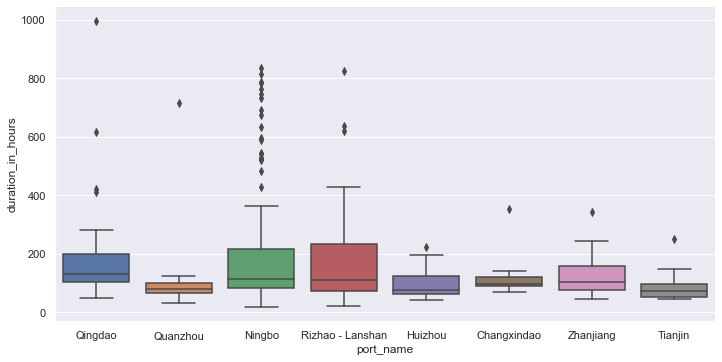

In [ ]:
common_discharge_ports_china = discharges_china['port_name'].value_counts().head(8)
common_port_discharges_china = discharges_china[discharges_china['port_name'].isin(common_discharge_ports_china.index)]
sns.catplot(x="port_name", y="duration_in_hours", kind="box", data=common_port_discharges_china, aspect=2);

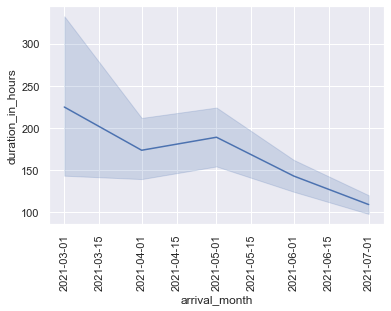

In [ ]:
discharges_china['arrival_month'] = discharges_china['arrival_date'].dt.tz_localize(None).dt.to_period('M').dt.to_timestamp()
sns.lineplot(data=discharges_china, x='arrival_month', y='duration_in_hours')
plt.xticks(rotation=90);

### Discharge destinations

In [ ]:
discharge_destinations_brazil = voyages[voyages['load_country']=='Brazil'].dropna(subset=['discharge_country'])

In [ ]:
discharge_destinations_brazil['discharge_country'].value_counts()

China                 45
Korea, Republic of     4
India                  4
Singapore              3
Japan                  1
Brazil                 1
United States          1
Name: discharge_country, dtype: int64

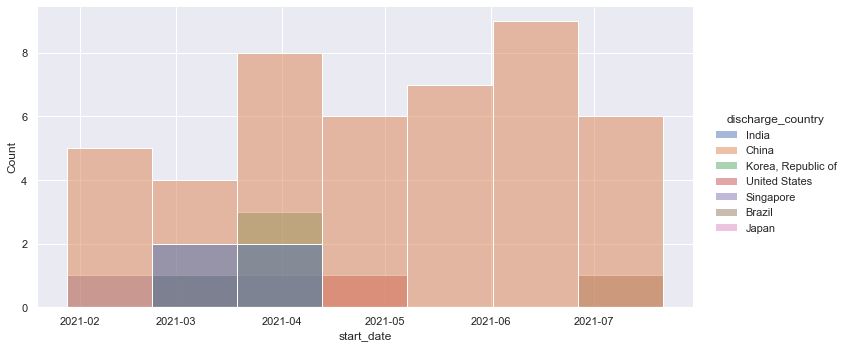

In [ ]:
sns.displot(discharge_destinations_brazil, x="start_date", hue="discharge_country", aspect=2);

### Advanced Voyage Search: Discharge origins

This use-case demonstrates how to utilise the advanced search endpoint to extract historical voyages by `vessel_class_id`, `first_load_arrival_date` and a specific `event_purpose`. The voyages with the provided purpose can then be merged and filtered with a specific `load_area` and `discharge_country` in order to visualize the vessel flows into the specified country.

In [ ]:
# get vessel class id for vlcc
vessel_class = api.get_vessel_classes(VesselClassFilter('vlcc'))
vlcc_id = vessel_class[0].vessel_class_id
vlcc_id

84

In [ ]:
date_from = date.today() - timedelta(days=60)
load_area = 'Arabian Gulf'
discharge_country = 'Japan'

In the following cell we extract the voyages with an `event_purpose="Discharge"`, which essentially looks up for all the voyages with *at least one discharge event*. This implies, due to the nature of the shipping pipeline, that load events are also included in the discharge call and can therefore be omitted.

In [ ]:
voyages = api.get_voyages_by_advanced_search(vessel_class_id=vlcc_id, first_load_arrival_date_from=date_from,
                                                              event_horizon='Historical', event_purpose='Discharge')

voyages = pd.DataFrame(v.__dict__ for v in voyages)

In [ ]:
voyages['load_area'] = voyages['events'].apply(get_voyage_load_area)
voyages['load_country'] = voyages['events'].apply(get_voyage_load_country)
voyages['discharge_country'] = voyages['events'].apply(get_voyage_discharge_country)

In [ ]:
voyages_filtered = voyages.loc[(voyages['load_area'] == load_area) & (voyages['discharge_country'] == discharge_country)].reset_index(drop=True)

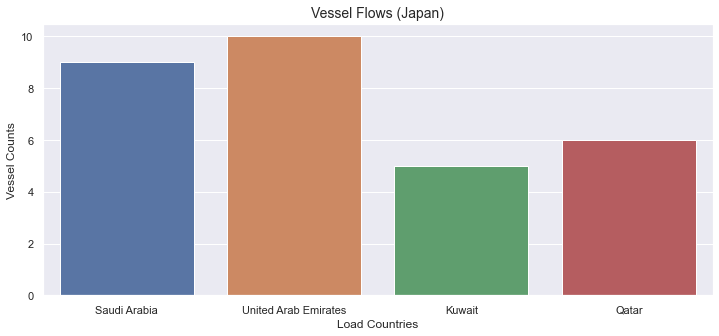

In [ ]:
fig, _ = plt.subplots(figsize=(12, 5))
ax = sns.countplot(x='load_country', data=voyages_filtered)

ax.set_title(f'Vessel Flows ({discharge_country})', fontsize=14)
ax.set_xlabel('Load Countries', fontsize=12)
ax.set_ylabel('Vessel Counts', fontsize=12);